In [1]:
from gentype import EnsemblClient, DataManager, PiCollapsedNonparametricGibbsSampler
import matplotlib.pyplot as plt
import numpy as np

Set up Classes:

In [2]:
Database_Name = "Gentype_DB"
client = EnsemblClient()
data_manager = DataManager(client, Database_Name)

The following will fill the Database which can be expected to take a while. If the database was already filled it is not necessary to execute the cell below.
You can however copy and alter specific statements to fetch different data.
In order to inspect the resulting database I recommend https://sqlitebrowser.org/.
The database should be found in the same directory as this notebook.

In [3]:
data_manager.fetch_reference_set()
data_manager.fetch_reference_sequences("GRCh38")
data_manager.fetch_populations(pop_filter = None)
# fetch_individuals defaults to ALL
data_manager.fetch_individuals()
#in order to relate the individuals to specific populations we need to fetch them with respect to that population
data_manager.fetch_individuals("CHB", "1000GENOMES:phase_3") 
data_manager.fetch_variants(17671934, 17681934, "22")

The following generates a inference matrix from the data provided by the local database. The inference matrix can be constructed with respect to a population and a section specified by start and end. Be sure to fetch the according population before constructing the matrix. If _sum_allels = True_ is passed, the expression for an individual per allele will be summed (if expressed on both -> 2, on one -> 1, on neither -> 0). Otherwise each strand will be represented by a seperate row.

idv_map and var_map map the used individuals / variations to the corresponding row/column in the inference matrix.

In [4]:
inference_matrix, idv_map, var_map = data_manager.generate_inference_matrix(start = 17671934, end = 17681934, population = "CHB")
inference_matrix.shape

(206, 279)

The following cell runs the sampler using the inference matrix.

Iteration: 1; Current clusters: 3; Likelihood:  -7076.348
Iteration: 2; Current clusters: 3; Likelihood:  -7032.508
Iteration: 3; Current clusters: 2; Likelihood:  -6971.953
Iteration: 4; Current clusters: 2; Likelihood:  -6978.917
Iteration: 5; Current clusters: 2; Likelihood:  -6979.027
Iteration: 6; Current clusters: 2; Likelihood:  -6973.055
Iteration: 7; Current clusters: 2; Likelihood:  -6982.961
Iteration: 8; Current clusters: 2; Likelihood:  -6985.855
Iteration: 9; Current clusters: 2; Likelihood:  -6975.861
Iteration: 10; Current clusters: 2; Likelihood:  -7004.473
Iteration: 11; Current clusters: 2; Likelihood:  -6993.524
Iteration: 12; Current clusters: 2; Likelihood:  -6985.737
Iteration: 13; Current clusters: 2; Likelihood:  -7013.476
Iteration: 14; Current clusters: 2; Likelihood:  -6956.935
Iteration: 15; Current clusters: 2; Likelihood:  -6999.958
Iteration: 16; Current clusters: 2; Likelihood:  -6982.080
Iteration: 17; Current clusters: 2; Likelihood:  -6964.833
Iterat

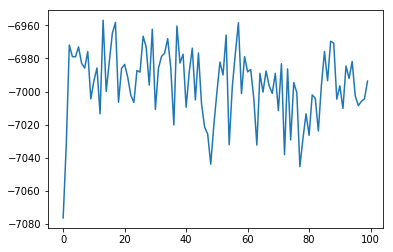

In [5]:
sampler = PiCollapsedNonparametricGibbsSampler(1)
sampler.fit(inference_matrix, num_burn_in_steps = 100, delta = 2)
plt.plot(sampler.ll_list)

The following generates the distribution (as a dict) of amount of variations per strand in the specified region. I.e. {n : #strands with n variations}. And chooses one of the amounts according to the distribution.

In [6]:
distribution = data_manager.get_variation_distribution(start = 17671934, end = 17681934, population = "CHB")
choices = []
probabilities = []
for choice in distribution:
    choices.append(choice)
    probabilities.append(distribution[choice])
choices = np.array(choices)
probabilities = np.array(probabilities) / sum(probabilities)
print("Choices: {}".format(choices))
print("Probabilities: {}".format(probabilities))
np.random.choice(choices, p=probabilities)

Choices: [13 14  1 12 10  9 15  0  2]
Probabilities: [0.59708738 0.12621359 0.02427184 0.0776699  0.00485437 0.09223301
 0.04368932 0.00970874 0.02427184]


13